In [820]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#
#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
#
#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification(free_location=False):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, free_location)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)
    
    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Part III : Simple classification

#### We train two neural nets using a stochastic gradient descent and an Adam optimizer. 
#### We train them on 300 noised images of rectangles, circles and triangles and evaluate the performances of the respective algorithms on a testing set of the same size.

In [821]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import utils as np_utils
from keras.optimizers import SGD, Adam
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_test, Y_test] = generate_test_set_classification()
# Generate dummy data
data = X_train
labels = np_utils.to_categorical(Y_train,3)

### Neural net with Adam optimizer

In [809]:
model_Adam = Sequential()
#model_Adam.add(Dense(3, activation='relu', input_dim = IMAGE_SIZE**2))
model_Adam.add(Dense(3, activation='softmax'))
optim_Adam = Adam(lr = 0.00005, beta_1 = .9 , beta_2 = .999, epsilon = None, decay = 0.000005, amsgrad = False)
model_Adam.compile(optimizer = optim_Adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_Adam.fit(data, labels, epochs=250, batch_size=32)

Epoch 1/250
300/300 [==============================] - 10s 33ms/step - loss: 1.2312 - acc: 0.4033
Epoch 2/250
300/300 [==============================] - 0s 157us/step - loss: 1.0950 - acc: 0.3833
Epoch 3/250
300/300 [==============================] - 0s 181us/step - loss: 1.0159 - acc: 0.5267
Epoch 4/250
300/300 [==============================] - 0s 183us/step - loss: 0.9738 - acc: 0.5733
Epoch 5/250
300/300 [==============================] - 0s 172us/step - loss: 0.9231 - acc: 0.5900
Epoch 6/250
300/300 [==============================] - 0s 171us/step - loss: 0.8802 - acc: 0.6400
Epoch 7/250
300/300 [==============================] - 0s 164us/step - loss: 0.8476 - acc: 0.6900
Epoch 8/250
300/300 [==============================] - 0s 171us/step - loss: 0.8049 - acc: 0.6200
Epoch 9/250
300/300 [==============================] - 0s 156us/step - loss: 0.7774 - acc: 0.6600
Epoch 10/250
300/300 [==============================] - 0s 163us/step - loss: 0.7465 - acc: 0.7400
Epoch 11/250
300/30

300/300 [==============================] - 0s 179us/step - loss: 0.2009 - acc: 0.9800
Epoch 84/250
300/300 [==============================] - 0s 192us/step - loss: 0.1971 - acc: 0.9800
Epoch 85/250
300/300 [==============================] - 0s 174us/step - loss: 0.1961 - acc: 0.9933
Epoch 86/250
300/300 [==============================] - 0s 177us/step - loss: 0.1977 - acc: 0.9800
Epoch 87/250
300/300 [==============================] - 0s 194us/step - loss: 0.1936 - acc: 0.9833
Epoch 88/250
300/300 [==============================] - 0s 197us/step - loss: 0.1884 - acc: 0.9833
Epoch 89/250
300/300 [==============================] - 0s 189us/step - loss: 0.1880 - acc: 0.9800
Epoch 90/250
300/300 [==============================] - 0s 195us/step - loss: 0.1865 - acc: 0.9967
Epoch 91/250
300/300 [==============================] - 0s 193us/step - loss: 0.1836 - acc: 0.9800
Epoch 92/250
300/300 [==============================] - 0s 206us/step - loss: 0.1816 - acc: 0.9867
Epoch 93/250
300/300 [=

300/300 [==============================] - 0s 318us/step - loss: 0.0943 - acc: 0.9967
Epoch 166/250
300/300 [==============================] - 0s 336us/step - loss: 0.0936 - acc: 0.9967
Epoch 167/250
300/300 [==============================] - 0s 334us/step - loss: 0.0935 - acc: 0.9967
Epoch 168/250
300/300 [==============================] - 0s 335us/step - loss: 0.0924 - acc: 0.9967
Epoch 169/250
300/300 [==============================] - 0s 349us/step - loss: 0.0920 - acc: 0.9967
Epoch 170/250
300/300 [==============================] - 0s 327us/step - loss: 0.0915 - acc: 0.9967
Epoch 171/250
300/300 [==============================] - 0s 302us/step - loss: 0.0934 - acc: 0.9967
Epoch 172/250
300/300 [==============================] - 0s 317us/step - loss: 0.0905 - acc: 0.9967
Epoch 173/250
300/300 [==============================] - 0s 297us/step - loss: 0.0892 - acc: 0.9967
Epoch 174/250
300/300 [==============================] - 0s 312us/step - loss: 0.0884 - acc: 0.9967
Epoch 175/250


300/300 [==============================] - 0s 311us/step - loss: 0.0540 - acc: 0.9967
Epoch 248/250
300/300 [==============================] - 0s 311us/step - loss: 0.0537 - acc: 0.9967
Epoch 249/250
300/300 [==============================] - 0s 302us/step - loss: 0.0534 - acc: 0.9967
Epoch 250/250
300/300 [==============================] - 0s 305us/step - loss: 0.0546 - acc: 0.9967


### Neural net with stochastic gradient descent

In [810]:
model_sto = Sequential()
#model_sto.add(Dense(3, activation='relu', input_dim = IMAGE_SIZE**2))
model_sto.add(Dense(3, activation='softmax'))
optim_sto = keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.000001, nesterov=False)
model_sto.compile(optimizer = optim_sto,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Train the model, iterating on the data in batches of 32 samples
model_sto.fit(data, labels, epochs=250, batch_size=32)



#model.compile(optimizer = optim,
#              loss='mean_squared_error',
#              metrics=['accuracy'])




Epoch 1/250
300/300 [==============================] - 10s 32ms/step - loss: 1.1410 - acc: 0.4167
Epoch 2/250
300/300 [==============================] - 0s 170us/step - loss: 1.0231 - acc: 0.4833
Epoch 3/250
300/300 [==============================] - 0s 153us/step - loss: 0.9074 - acc: 0.6167
Epoch 4/250
300/300 [==============================] - 0s 159us/step - loss: 0.8139 - acc: 0.6967
Epoch 5/250
300/300 [==============================] - 0s 166us/step - loss: 0.7944 - acc: 0.6967
Epoch 6/250
300/300 [==============================] - 0s 166us/step - loss: 0.7154 - acc: 0.7300
Epoch 7/250
300/300 [==============================] - 0s 164us/step - loss: 0.6842 - acc: 0.7633
Epoch 8/250
300/300 [==============================] - 0s 161us/step - loss: 0.6499 - acc: 0.7600
Epoch 9/250
300/300 [==============================] - 0s 155us/step - loss: 0.6158 - acc: 0.8200
Epoch 10/250
300/300 [==============================] - 0s 161us/step - loss: 0.5908 - acc: 0.8000
Epoch 11/250
300/30

300/300 [==============================] - 0s 277us/step - loss: 0.1982 - acc: 0.9700
Epoch 84/250
300/300 [==============================] - 0s 293us/step - loss: 0.1935 - acc: 0.9733
Epoch 85/250
300/300 [==============================] - 0s 290us/step - loss: 0.1902 - acc: 0.9833
Epoch 86/250
300/300 [==============================] - 0s 293us/step - loss: 0.1880 - acc: 0.9800
Epoch 87/250
300/300 [==============================] - 0s 287us/step - loss: 0.1895 - acc: 0.9767
Epoch 88/250
300/300 [==============================] - 0s 284us/step - loss: 0.1841 - acc: 0.9800
Epoch 89/250
300/300 [==============================] - 0s 293us/step - loss: 0.1819 - acc: 0.9800
Epoch 90/250
300/300 [==============================] - 0s 289us/step - loss: 0.1841 - acc: 0.9733
Epoch 91/250
300/300 [==============================] - 0s 264us/step - loss: 0.1856 - acc: 0.9833
Epoch 92/250
300/300 [==============================] - 0s 274us/step - loss: 0.1785 - acc: 0.9767
Epoch 93/250
300/300 [=

300/300 [==============================] - 0s 304us/step - loss: 0.1178 - acc: 0.9933
Epoch 166/250
300/300 [==============================] - 0s 300us/step - loss: 0.1173 - acc: 0.9900
Epoch 167/250
300/300 [==============================] - 0s 281us/step - loss: 0.1150 - acc: 0.9933
Epoch 168/250
300/300 [==============================] - 0s 310us/step - loss: 0.1148 - acc: 0.9900
Epoch 169/250
300/300 [==============================] - 0s 305us/step - loss: 0.1153 - acc: 0.9933
Epoch 170/250
300/300 [==============================] - 0s 299us/step - loss: 0.1139 - acc: 0.9967
Epoch 171/250
300/300 [==============================] - 0s 317us/step - loss: 0.1132 - acc: 0.9933
Epoch 172/250
300/300 [==============================] - 0s 281us/step - loss: 0.1128 - acc: 0.9933
Epoch 173/250
300/300 [==============================] - 0s 307us/step - loss: 0.1112 - acc: 0.9900
Epoch 174/250
300/300 [==============================] - 0s 314us/step - loss: 0.1135 - acc: 0.9967
Epoch 175/250


300/300 [==============================] - 0s 298us/step - loss: 0.0845 - acc: 0.9967
Epoch 248/250
300/300 [==============================] - 0s 275us/step - loss: 0.0849 - acc: 0.9967
Epoch 249/250
300/300 [==============================] - 0s 288us/step - loss: 0.0837 - acc: 0.9967
Epoch 250/250
300/300 [==============================] - 0s 302us/step - loss: 0.0835 - acc: 0.9967


In [811]:
model_Adam.evaluate(X_test, Y_test)

300/300 [==============================] - 4s 14ms/step


[0.09002781629562379, 0.9700000007947286]

In [812]:
model_sto.evaluate(X_test, Y_test)

300/300 [==============================] - 4s 13ms/step


[0.1369520264863968, 0.9666666674613953]

#### With the stochastic gradient descent, we use a learning rate of 0.001 while with the Adam optimimzer we use a learning rate of 0.00005. We need to test the neaural net on data for which free_location is False so we've modified the generate_test_set_classification function to allow this variable to take the value True or False. In both cases we run 250 epochs with a batch of 32 and the categorical entropy loss.



# Part IV : Visualization of the solution
### Let's now visualize the weights of the last layer's node for each neural net

Text(0.5, 1.0, 'Sto node 3 (triangle)')

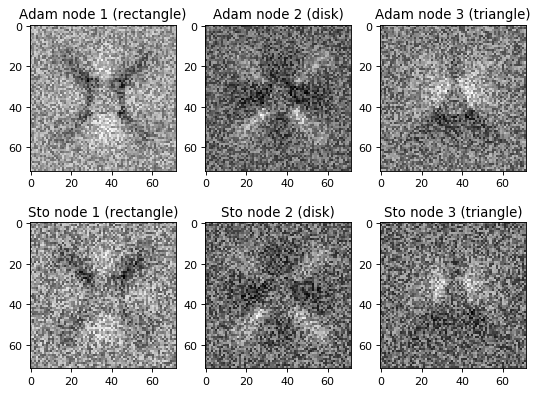

In [835]:
from pylab import *
Z = model_Adam.get_weights()[0]

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(231)
plt.imshow(Z[:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
title('Adam node 1 (rectangle)')
plt.subplot(232)
plt.imshow(Z[:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
title('Adam node 2 (disk)')
plt.subplot(233)
plt.imshow(Z[:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
title('Adam node 3 (triangle)')

Z_sto = model_sto.get_weights()[0]
plt.subplot(234)
plt.imshow(Z_sto[:,0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
title('Sto node 1 (rectangle)')
plt.subplot(235)
plt.imshow(Z_sto[:,1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
title('Sto node 2 (disk)')
plt.subplot(236)
plt.imshow(Z_sto[:,2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
title('Sto node 3 (triangle)')



# PART V : A more difficult classification problem

#### We train a 2D convolutional neural network on 30 epochs with Adam optimizer using 16 5 times 5 filters, 1 pooling layer and 1 fully connected layer. We still use on 300 training data. 

In [822]:
[X_train, Y_train] = generate_dataset_classification(300, 20,True)
[X_test, Y_test] = generate_test_set_classification(True)

In [608]:
X_train= X_train.reshape(X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_train= X_train.astype('float32')
print(X_train.shape)

X_test= X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
X_test= X_test.astype('float32')

data = X_train
labels = np_utils.to_categorical(Y_train,3)




(300, 72, 72, 1)


In [613]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


conv_Adam = Sequential()
conv_Adam.add(Conv2D(16, kernel_size = (5,5), strides = (1,1), activation='relu', input_shape = (IMAGE_SIZE,IMAGE_SIZE,1)))
conv_Adam.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
conv_Adam.add(Flatten())
conv_Adam.add(Dense(3, activation='softmax'))

optim_Adam = Adam(lr = 0.001, beta_1 = .9 , beta_2 = .999, epsilon = 1e-8, decay = 0.0000005, amsgrad = False)
conv_Adam.compile(optimizer = optim_Adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

conv_Adam.fit(data, labels, epochs=30, batch_size=32)



Epoch 1/30
300/300 [==============================] - 9s 31ms/step - loss: 1.3789 - acc: 0.3767
Epoch 2/30
300/300 [==============================] - 0s 1ms/step - loss: 0.9437 - acc: 0.6233
Epoch 3/30
300/300 [==============================] - 0s 1ms/step - loss: 0.8440 - acc: 0.6967
Epoch 4/30
300/300 [==============================] - 0s 1ms/step - loss: 0.7259 - acc: 0.8000
Epoch 5/30
300/300 [==============================] - 0s 2ms/step - loss: 0.7451 - acc: 0.7000
Epoch 6/30
300/300 [==============================] - 1s 2ms/step - loss: 0.6486 - acc: 0.7500
Epoch 7/30
300/300 [==============================] - 1s 3ms/step - loss: 0.5843 - acc: 0.8633
Epoch 8/30
300/300 [==============================] - 1s 4ms/step - loss: 0.5216 - acc: 0.8933
Epoch 9/30
300/300 [==============================] - 1s 4ms/step - loss: 0.4965 - acc: 0.8367
Epoch 10/30
300/300 [==============================] - 1s 3ms/step - loss: 0.4597 - acc: 0.8700
Epoch 11/30
300/300 [===========================

In [614]:
conv_Adam.evaluate(X_test, Y_test)

300/300 [==============================] - 4s 14ms/step


[0.6852376357714335, 0.7199999992052714]

#### The value of the loss function on the training set is 0.1351 and on the testing set it is 0.6852. The accuracy on the trainig set after 30 epochs is 99% whereas it is 72% on the testing set.

# Part VI : A regression problem

In [824]:
X_tr_classif = 0
X_te_classif = 0
Y_tr_classif = 0
Y_te_classif = 0

[X_tr_reg, Y_tr_reg] = generate_dataset_regression(300, 20)
[X_te_reg, Y_te_reg] = generate_test_set_regression()

#### We first sort the coordinates of the triangles by increasing order of the absciss in order to better train the algorithm

In [826]:
import operator

#We sort the coordinates by increasing order of the absciss
def sort_coord(l): 
    [a,b,c,d,e,f] = l
    v = list([[a,b],[c,d],[e,f]])
    v.sort(key = operator.itemgetter(0))
    [[a,b],[c,d],[e,f]] = v
    return([a,b,c,d,e,f])
    
Y_tr_reg = np.apply_along_axis(sort_coord,1,Y_tr_reg)

In [827]:
X_tr_reg= X_tr_reg.reshape(X_tr_reg.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
print(X_tr_reg.shape)

X_te_reg= X_te_reg.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

(300, 72, 72, 1)


In [828]:
reg_Adam = Sequential()
#model_Adam.add(Dense(100, activation='relu', input_dim = IMAGE_SIZE**2))

reg_Adam.add(Conv2D(16, (5,5), activation='relu', input_shape = (IMAGE_SIZE,IMAGE_SIZE,1)))
reg_Adam.add(MaxPooling2D(pool_size=(2, 2)))
reg_Adam.add(Conv2D(32, (5,5), activation='relu'))
reg_Adam.add(MaxPooling2D(pool_size=(2, 2)))
reg_Adam.add(Flatten())
reg_Adam.add(Dense(100, activation='relu'))
reg_Adam.add(Dense(6))


optim_Adam = Adam(lr = 0.001, beta_1 = .9 , beta_2 = .999, epsilon = None, decay = 0.000001, amsgrad = False)
reg_Adam.compile(optimizer = optim_Adam,
              loss='mse',
              metrics=['mse'])

reg_Adam.fit(X_tr_reg, Y_tr_reg, epochs=50, batch_size=32)

Epoch 1/50
300/300 [==============================] - 11s 38ms/step - loss: 0.1611 - mean_squared_error: 0.1611
Epoch 2/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0602 - mean_squared_error: 0.0602
Epoch 3/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0409 - mean_squared_error: 0.0409
Epoch 4/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0306 - mean_squared_error: 0.0306
Epoch 5/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0243 - mean_squared_error: 0.0243
Epoch 6/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 7/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 8/50
300/300 [==============================] - 1s 4ms/step - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 9/50
300/300 [==============================] - 2s 5ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 10

#### Predictions on the training set


<Figure size 80x80 with 0 Axes>

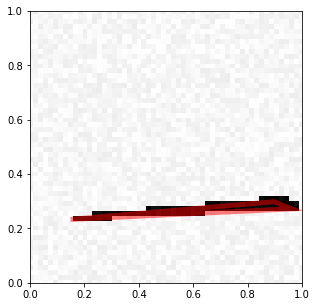

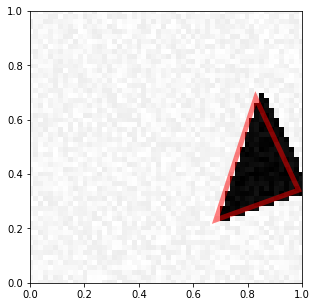

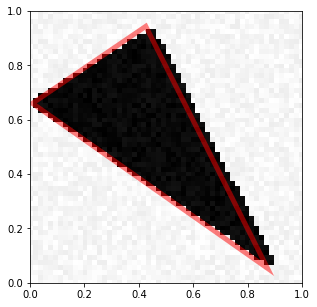

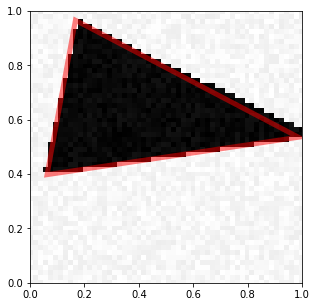

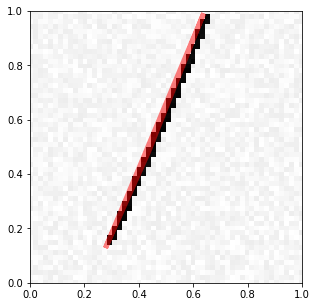

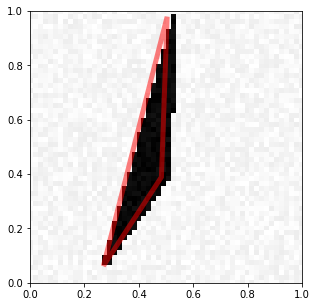

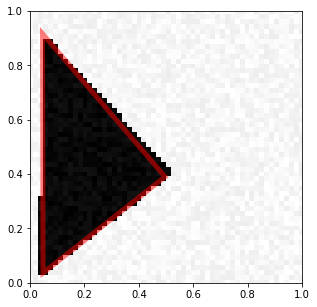

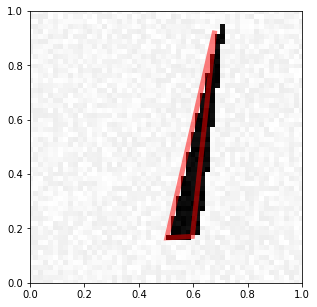

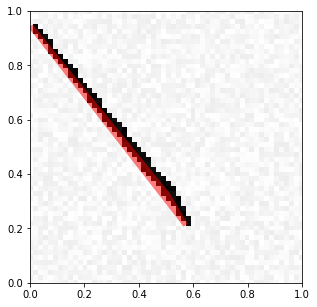

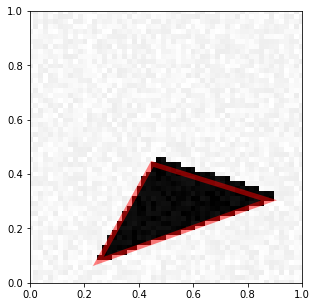

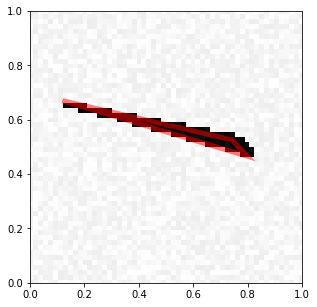

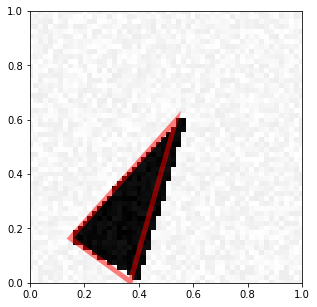

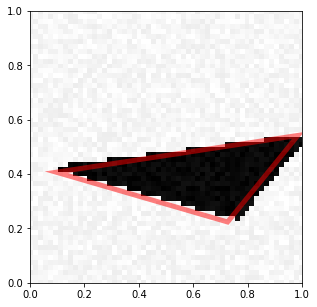

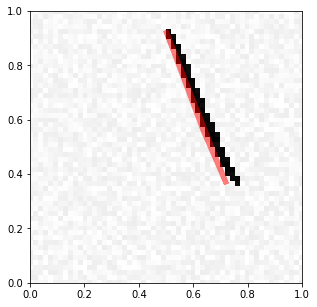

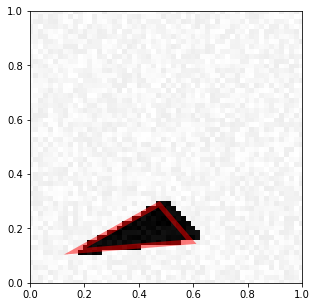

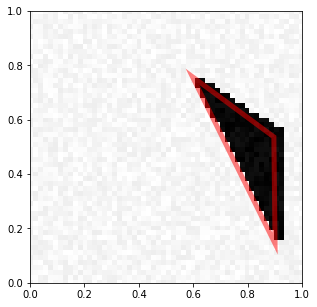

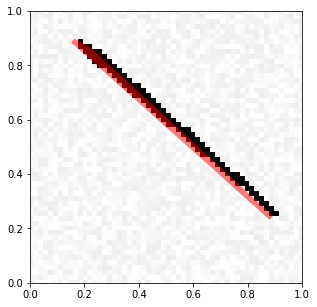

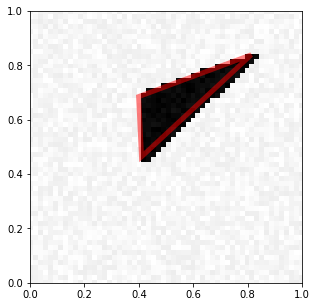

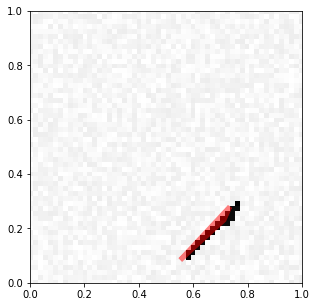

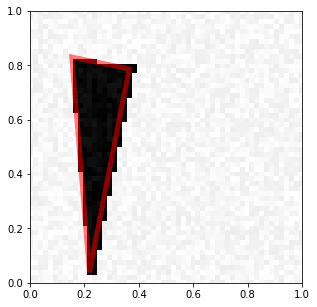

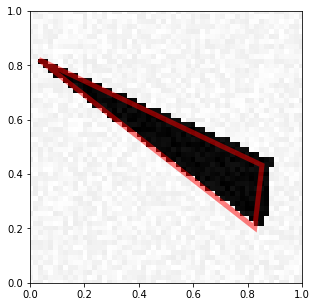

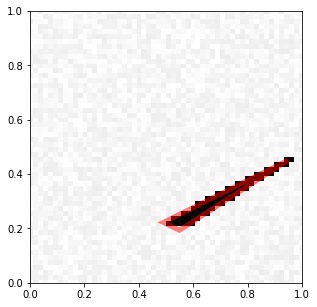

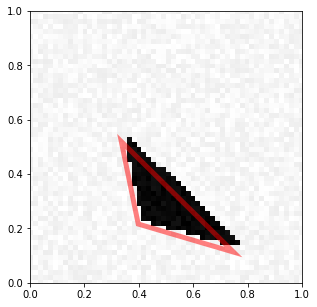

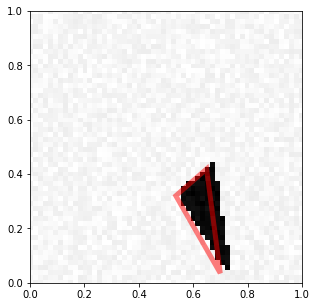

In [830]:
u=reg_Adam.predict(X_tr_reg)
figure(num=None, figsize=(1, 1), dpi=80, facecolor='w', edgecolor='k')
for i in range(1,25):
    visualize_prediction(X_tr_reg[i],u[i])


#### Predictions on the testing set

<Figure size 80x80 with 0 Axes>

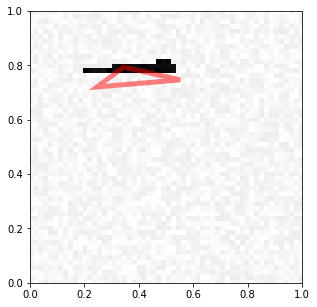

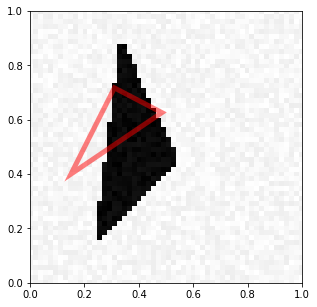

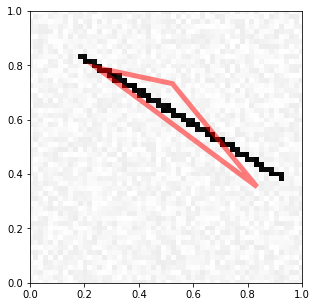

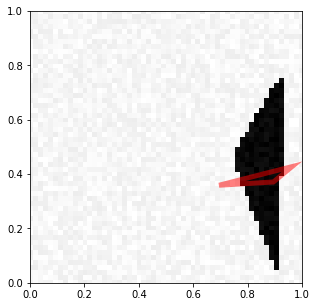

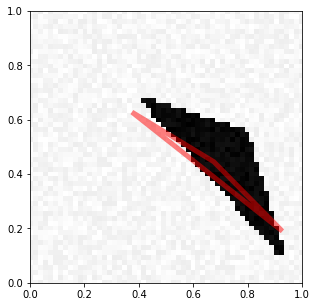

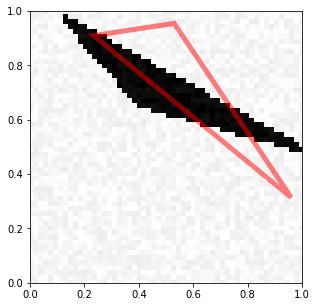

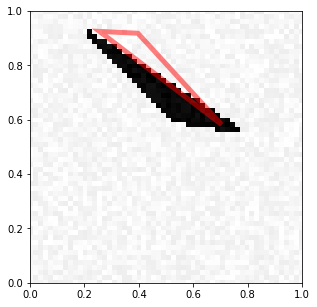

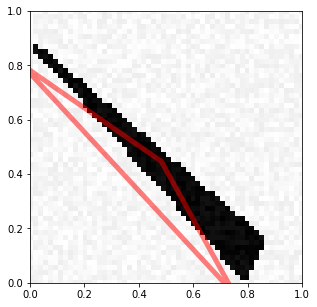

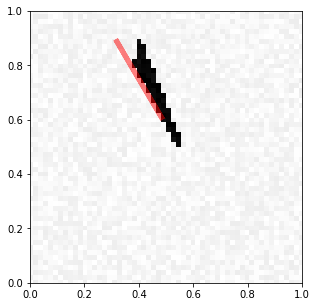

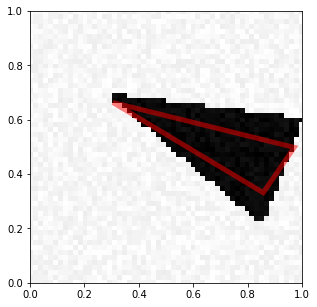

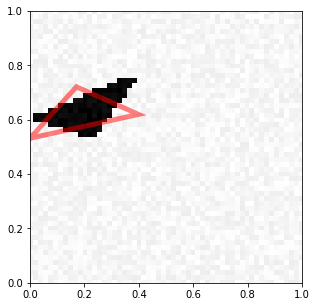

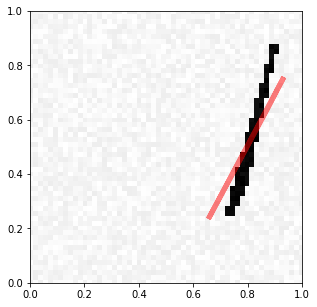

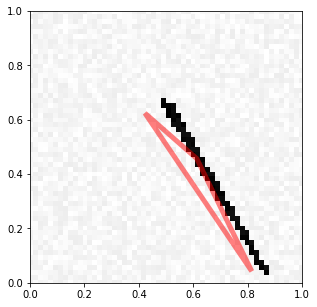

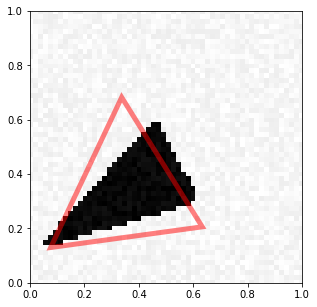

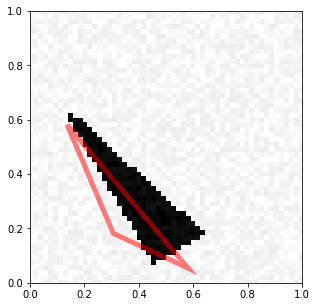

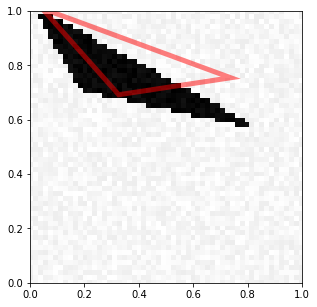

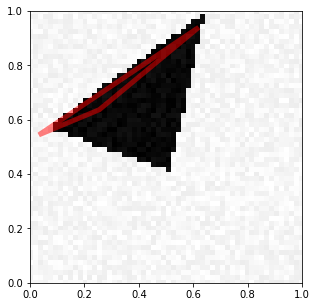

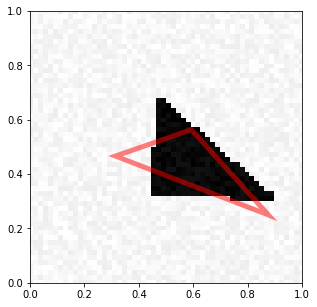

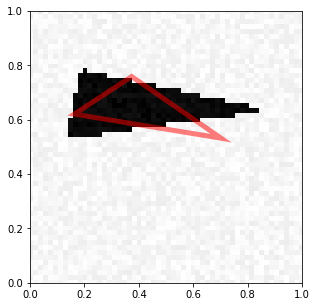

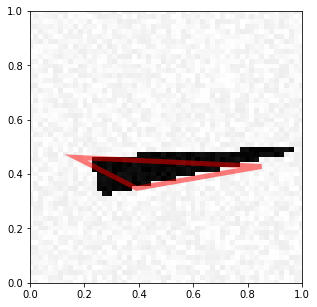

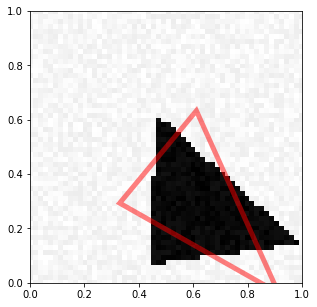

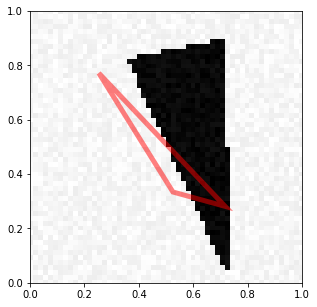

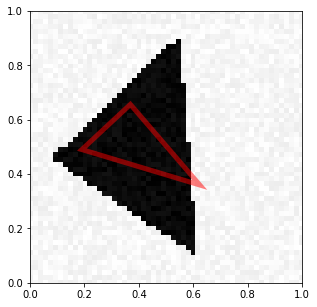

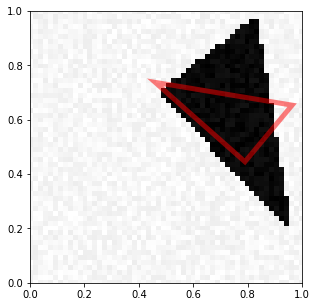

In [831]:
v=reg_Adam.predict(X_te_reg)
figure(num=None, figsize=(1, 1), dpi=80, facecolor='w', edgecolor='k')
for i in range(1,25):
    visualize_prediction(X_te_reg[i],v[i])



In [832]:
reg_Adam.evaluate(X_te_reg,Y_te_reg)

300/300 [==============================] - 5s 16ms/step


[0.10181799471378326, 0.10181799471378326]

#### As we can see the result is not very satisfactory, there seems to be a lot of overfitting so that the loss on the testing set is actually quite large